In [20]:
import os
import pandas as pd
import numpy as np


directory = '/Users/gregorycousins/Gonnorhea_proj/results/data/simulation_results'


files = os.listdir(directory)

# Filter out files that are not CSV
csv_files = [file for file in files if file.endswith('.csv')]

# Sort the files by their creation time (newest first)
csv_files.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# Select the most recent file
latest_file = csv_files[0]

# Create the full path to the latest file
latest_file_path = os.path.join(directory, latest_file)

# Read the latest CSV file into a DataFrame
data_df = pd.read_csv(latest_file_path)

data_df = data_df.sort_values(by=["Tau"], ascending=True)




In [21]:
data_df.head(100)

,Tau,Average Total Infections,Infections Std Dev,Infections Conf Interval Lower,Infections Conf Interval Upper,"Upper Confidence Bound, Total Infections",Average Total Detected Cases,Detected Cases Std Dev,Detected Cases Conf Interval Lower,Detected Cases Conf Interval Upper,"Upper Confidence Bound, Total Detected Cases",Average Percent Detected Cases,Percent Detected Cases Std Dev,Percent Detected Conf Interval Lower,Percent Detected Conf Interval Upper,"Upper Confidence Bound, Percent Detected Cases"
4,1,3280.852743,13654.357358,3013.232256,3548.473229,35054.469351,2461.922872,10665.346307,2252.885925,2670.959818,26373.522073,0.757138,0.150372,0.754191,0.760085,0.759612
13,2,3682.951383,15188.748202,3385.257388,3980.645377,39327.840582,2827.053850,12193.809267,2588.059580,3066.048120,30276.241642,0.765735,0.144552,0.762901,0.768568,0.768112
10,3,3982.654510,15594.577409,3677.006409,4288.302611,42391.624819,3057.527546,12456.719840,2813.380323,3301.674768,32624.223540,0.772130,0.149358,0.769203,0.775058,0.774587
8,4,4321.522574,16447.338595,3999.160661,4643.884487,45920.572194,3347.381395,13376.039618,3085.215836,3609.546954,35673.976679,0.773582,0.152841,0.770587,0.776578,0.776096
0,5,4611.178437,17160.978295,4274.829443,4947.527431,48934.514108,3585.277270,14126.703978,3308.398960,3862.155580,38176.408724,0.770691,0.141042,0.767926,0.773455,0.773011
1,6,4823.740499,17245.641327,4485.732140,5161.748858,51074.060561,3744.783664,14094.748473,3468.531670,4021.035658,39766.216456,0.771513,0.151061,0.768553,0.774474,0.773998
2,7,5466.574679,19121.613703,5091.797937,5841.351421,57810.972356,4252.665551,15707.983510,3944.794732,4560.536371,45110.388878,0.773114,0.153490,0.770105,0.776122,0.775639
9,8,5738.156330,19340.018259,5359.098937,6117.213722,60562.713218,4470.180618,15845.159543,4159.621198,4780.740039,47308.102997,0.769523,0.143547,0.766710,0.772337,0.771884
12,9,6089.249304,19800.351239,5701.169551,6477.329057,64149.360991,4737.482539,16230.879325,4419.363150,5055.601928,50044.567461,0.770518,0.145511,0.767666,0.773370,0.772912
7,10,6556.798612,20418.329548,6156.606707,6956.990518,68926.502463,5066.652918,16630.100472,4740.708938,5392.596898,53401.937285,0.766399,0.141959,0.763617,0.769181,0.768734


In [22]:
# Parameters

cost_test = 3.50
cost_treat = 41.95
cost_tr_diss = 10000
p_3months = 0.3          # Proportion tested every 3 months
p_12months = 1-p_3months         # Proportion tested every 12 months
# The (weighted) average testing proportion for our population (proportion per day)
average_daily_testing_proportion = (p_3months/91 + p_12months/365)


In [23]:
total_cost = []
lower_bound_total_cost = []
upper_bound_total_cost = []

for tau in data_df['Tau']:
    if float(tau).is_integer():
        row_index = data_df[data_df['Tau'] == tau].index[0]
        cases_at_tau = data_df.loc[row_index, 'Average Total Detected Cases']
       
        lower_bound_cases = data_df.loc[row_index, 'Detected Cases Conf Interval Lower']
       
        upper_bound_cases = data_df.loc[row_index, 'Detected Cases Conf Interval Upper']

        base_cost = cost_test * 100000 * 365 * average_daily_testing_proportion
        cost_factor = cost_treat + 0.03 * cost_tr_diss

        total_cost.append([tau, base_cost + cases_at_tau * cost_factor])
        lower_bound_total_cost.append([tau, base_cost + lower_bound_cases * cost_factor])
        upper_bound_total_cost.append([tau, base_cost + upper_bound_cases * cost_factor])


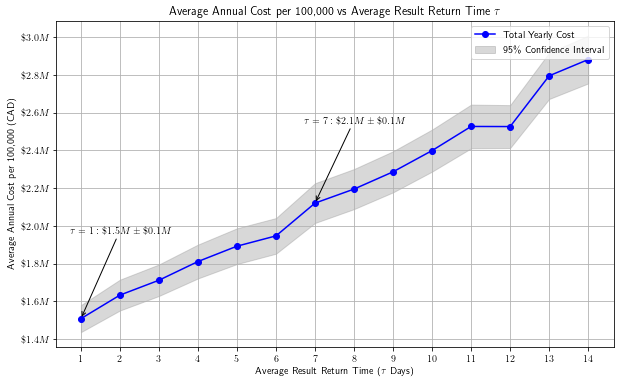

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Enable LaTeX rendering
plt.rc('text', usetex=True)

# Unpack the lists
taus, costs = zip(*total_cost)
_, lower_costs = zip(*lower_bound_total_cost)
_, upper_costs = zip(*upper_bound_total_cost)


# Create a plot
plt.figure(figsize=(10, 6))

# Plot the total cost
plt.plot(taus, costs, color='blue', marker='o', label='Total Yearly Cost')

# Plot the confidence intervals
plt.fill_between(taus, lower_costs, upper_costs, color='gray', alpha=0.3, label='95\\% Confidence Interval')

# Format the y-axis to be compatible with LaTeX
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'$\${:,.1f}M$'.format(x/1e6)))

# Set x-axis ticks to show each integer value of Tau
plt.xticks(taus)

plt.xlabel(r'Average Result Return Time ($\tau$ Days)')
plt.ylabel(r'Average Annual Cost per 100,000 (CAD)')
plt.title(r'Average Annual Cost per 100,000 vs Average Result Return Time $\tau$')
plt.legend()
plt.grid(True)

# Annotations for tau = 7 and tau = 1
cost_at_tau_7 = costs[taus.index(7)]  
cost_at_tau_1 = costs[taus.index(1)]  

# Calculate error values
error_at_tau_7 = upper_costs[taus.index(7)] - costs[taus.index(7)]
error_at_tau_1 = upper_costs[taus.index(1)] - costs[taus.index(1)]

# Annotation for tau = 7
plt.annotate(f'$\\tau=7: \\${costs[taus.index(7)]/1e6:.1f}M \\pm \\${error_at_tau_7/1e6:.1f}M$',
             xy=(7, costs[taus.index(7)]), xytext=(8, costs[taus.index(7)] * 1.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')

# Annotation for tau = 1
plt.annotate(f'$\\tau=1: \\${costs[taus.index(1)]/1e6:.1f}M \\pm \\${error_at_tau_1/1e6:.1f}M$',
             xy=(1, costs[taus.index(1)]), xytext=(2, costs[taus.index(1)] * 1.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')

file_path_econ = f'/Users/gregorycousins/Gonnorhea_proj/results/plots/econ_calc_annotated.png'

plt.savefig(file_path_econ)

plt.show()